In [2]:
%matplotlib notebook
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm_notebook as tqdm

textwidth = 4.
mpl.rcParams['axes.labelsize'] = 9.
mpl.rcParams['axes.titlesize'] = 9.
mpl.rcParams['xtick.labelsize'] = 9.
mpl.rcParams['ytick.labelsize'] = 9.
mpl.rcParams['legend.fontsize'] = 9.
mpl.rcParams['font.family'] = 'Open Sans'

In [14]:
N = 500

cf_w = .1
cf_w_in = 1.

sigm_w_e = 1.

eps_a = 10.**-3.
eps_b = 10.**-3.

eps_mu = 10.**-4.
eps_var = 10.**-3.

mu_y_target = -np.ones((N))*0.

#r_target = .9

T = 50000
T_skip_rec = 10
T_rec = int(T/T_skip_rec)

t_arr = np.arange(T_rec)*T_skip_rec

In [86]:
W = np.random.normal(0.,1./(cf_w*N)**.5,(N,N)) * (np.random.rand(N,N) <= cf_w)
W[range(N),range(N)] = 0.

#W = W/np.max(np.abs(np.linalg.eigvals(W)))

a = np.ones((N))*.5
b = np.zeros((N))

w_in = np.random.normal(0.,sigm_w_e,(N,1)) * (np.random.rand(N,1) <= cf_w_in)

u_in = (np.random.rand(1,T) >= .5)*1.

y = np.ndarray((N))
X_r = np.ndarray((N))
X_e = np.ndarray((N))
#X_e = (w_in @ u_in).T
#X_e = np.random.normal(0.,1.,(T,N)) * w_in[:,0]
#X_e = np.random.normal(0.,.25,(T,N))

X_r_y_ratio = 1.

mu_y = np.ndarray((N))
mu_X_e = np.ndarray((N))
Var_y = np.ndarray((N))
Var_X_e = np.ndarray((N))

### recording
a_rec = np.ones((T_rec,N))
b_rec = np.ones((T_rec,N))

y_rec = np.ones((T_rec,N))
X_r_rec = np.ones((T_rec,N))
X_e_rec = np.ones((T_rec,N))

X_r_y_ratio_rec = np.ones((T_rec))

mu_y_rec = np.ones((T_rec,N))
mu_X_e_rec = np.ones((T_rec,N))
Var_y_rec = np.ones((T_rec,N))
Var_X_e_rec = np.ones((T_rec,N))
###

### first time step
X_e[:] = w_in @ u_in[:,0]
X_r[:] = np.zeros((N))
y[:] = np.tanh(X_r[:] + X_e[:])

mu_y[:] = y
mu_X_e[:] = X_e
Var_y[:] = .25
Var_X_e[:] = .25

#### Recording
a_rec[0,:] = a
b_rec[0,:] = b

y_rec[0,:] = y
X_r_rec[0,:] = X_r
X_e_rec[0,:] = X_e

X_r_y_ratio_rec[0] = 0.

mu_y_rec[0,:] = mu_y
mu_X_e_rec[0,:] = mu_X_e
Var_y_rec[0,:] = Var_y
Var_X_e_rec[0,:] = Var_X_e
####
###

for t in tqdm(range(1,T)):
    
    X_r[:] = a[:] * (W @ y[:])
    
    X_e[:] = w_in @ u_in[:,t]
    #X_e[:] = w_in[:,0] * (np.random.rand(N) >= .5)
    
    if np.linalg.norm(y)**2. > 0.:
        X_r_y_ratio = np.linalg.norm(X_r)/np.linalg.norm(y)
    else:
        X_r_y_ratio = 1.
        
    y[:] = np.tanh(X_r + X_e - b)
        
    mu_y[:] = (1.-eps_mu)*mu_y + eps_mu * y
    mu_X_e[:] = (1.-eps_mu)*mu_X_e + eps_mu * X_e
    
    Var_y[:] = (1.-eps_var)*Var_y + eps_var * (y - mu_y)**2.
    Var_X_e[:] = (1.-eps_var)*Var_X_e + eps_var * (X_e - mu_X_e)**2.
        
    #a = a + eps_a * a * ((y**2.).mean() - (X_r**2.).mean())    
    a = a + eps_a * a * (1.-X_r_y_ratio)
    #a = a + eps_a * ((y**2.).mean() - (X_r**2.).mean())
    
    #a = a + eps_a * ((y**2.).mean() - X_r**2.)
    b = b + eps_b * (y - mu_y_target)
    
    a = np.maximum(0.1,a)    
    
    if t%T_skip_rec == 0:
        t_rec = int(t/T_skip_rec)
        
        #### Recording
        a_rec[t_rec,:] = a
        b_rec[t_rec,:] = b

        y_rec[t_rec,:] = y
        X_r_rec[t_rec,:] = X_r
        X_e_rec[t_rec,:] = X_e
        
        X_r_y_ratio_rec[t_rec] = X_r_y_ratio
        
        mu_y_rec[t_rec,:] = mu_y
        mu_X_e_rec[t_rec,:] = mu_X_e
        Var_y_rec[t_rec,:] = Var_y
        Var_X_e_rec[t_rec,:] = Var_X_e
        ####

<IPython.core.display.Javascript object>


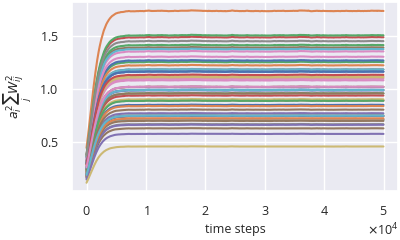

In [87]:
fig, ax = plt.subplots(figsize=(textwidth,0.6*textwidth))
ax.plot(t_arr,(a_rec**2.*(W**2.).sum(axis=1))[:,:50])
ax.set_xlabel("time steps")
ax.set_ylabel("$a^2_i \\sum_j W_{ij}^2$")
ax.ticklabel_format(style='sci',scilimits=(0,0),useMathText=True)
fig.tight_layout(pad=0.1)
fig.savefig('gain_dyn.pdf')
fig.savefig('gain_dyn.png',dpi=600)
plt.show()

<IPython.core.display.Javascript object>


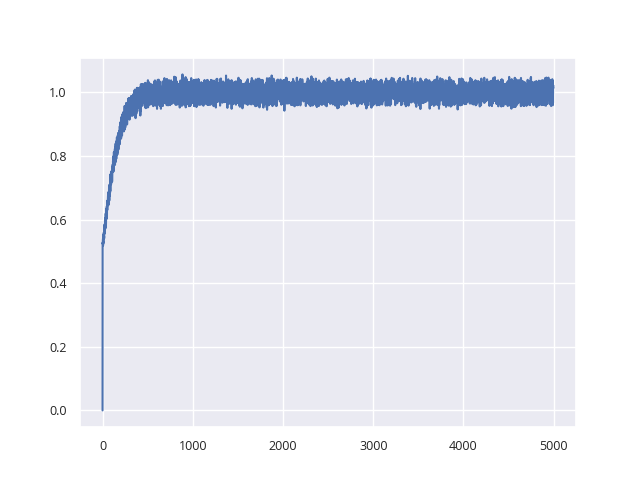

In [88]:
plt.figure()
plt.plot(X_r_y_ratio_rec)
plt.show()

<IPython.core.display.Javascript object>


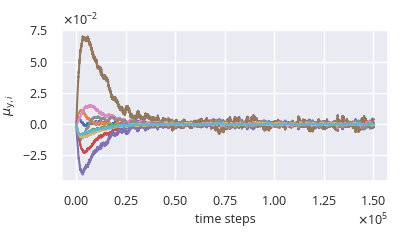

In [6]:
fig, ax = plt.subplots(figsize=(textwidth,0.6*textwidth))
ax.plot(t_arr,mu_y_rec[:,:10])
ax.set_xlabel("time steps")
ax.set_ylabel("$\\mu_{{\\rm y},i}$")
ax.ticklabel_format(style='sci',scilimits=(0,0),useMathText=True)
fig.tight_layout(pad=0.7)
fig.savefig('mu_y_dyn.pdf')
fig.savefig('mu_y_dyn.png',dpi=600)
plt.show()

<IPython.core.display.Javascript object>


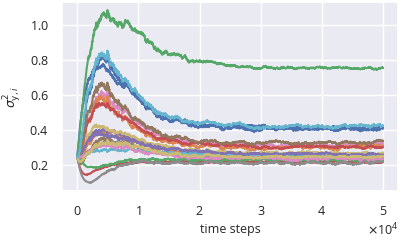

In [61]:
fig, ax = plt.subplots(figsize=(textwidth,0.6*textwidth))
ax.plot(t_arr,Var_y_rec[:,:20])
ax.set_xlabel("time steps")
ax.set_ylabel("$\\sigma^2_{{\\rm y},i}$")
ax.ticklabel_format(style='sci',scilimits=(0,0),useMathText=True)
fig.tight_layout(pad=0.1)
fig.savefig('sigm_squ_y_dyn.pdf')
fig.savefig('sigm_squ_y_dyn.png',dpi=600)
plt.show()

<IPython.core.display.Javascript object>


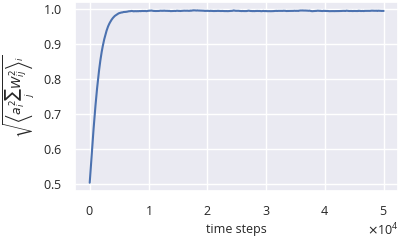

In [89]:
fig, ax = plt.subplots(figsize=(textwidth,0.6*textwidth))
ax.plot(t_arr,((a_rec**2)*(W**2).sum(axis=1)).mean(axis=1)**.5)
ax.set_xlabel("time steps")
ax.set_ylabel("$\\sqrt{\\left\\langle a^2_i \\sum_j W_{ij}^2 \\right\\rangle_i}$")
ax.ticklabel_format(style='sci',scilimits=(0,0),useMathText=True)
fig.tight_layout(pad=0.1)
fig.savefig('gain_mean_dyn.pdf')
fig.savefig('gain_mean_dyn.png',dpi=600)
plt.show()

<IPython.core.display.Javascript object>


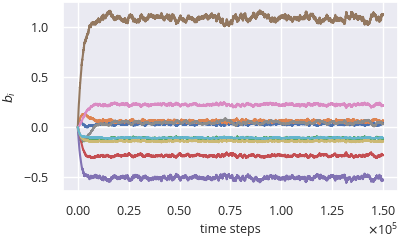

In [9]:
fig, ax = plt.subplots(figsize=(textwidth,0.6*textwidth))
ax.plot(t_arr,b_rec[:,:10])
ax.set_xlabel("time steps")
ax.set_ylabel("$b_i$")
ax.ticklabel_format(style='sci',scilimits=(0,0),useMathText=True)
fig.tight_layout(pad=0.1)
fig.savefig('bias_dyn.pdf')
fig.savefig('bias_dyn.png',dpi=600)
plt.show()

<IPython.core.display.Javascript object>


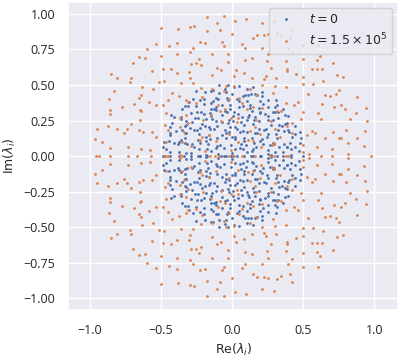

In [90]:
l1 = np.linalg.eigvals((W.T*a_rec[0,:]).T)
l2 = np.linalg.eigvals((W.T*a_rec[-1,:]).T)
fig, ax = plt.subplots(figsize=(textwidth,0.9*textwidth))
ax.plot(l1.real,l1.imag,'.',markersize=2,label='$t=0$')
ax.plot(l2.real,l2.imag,'.',markersize=2,label='$t=1.5 \\times 10^5$')
ax.axis('equal')
ax.set_xlabel("$\\mathrm{Re}\\left(\\lambda_i\\right)$")
ax.set_ylabel("$\\mathrm{Im}\\left(\\lambda_i\\right)$")
ax.legend()
fig.tight_layout(pad=0.1)
fig.savefig('eigvals.pdf')
fig.savefig('eigvals.png',dpi=600)
plt.show()

<IPython.core.display.Javascript object>


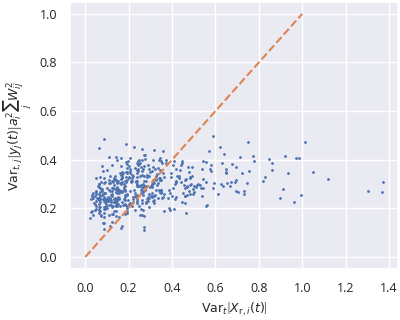

In [32]:
fig, ax = plt.subplots(figsize=(textwidth,0.8*textwidth))
x_val = X_r_rec[-5000:,:].var(axis=0)
y_val = y_rec[-5000:,:].var()*a_rec[-1,:]**2.*(W**2.).sum(axis=1)
ax.plot(x_val,y_val,'.',markersize=2)
ax.plot([0.,1.],[0.,1.],'--')
ax.set_xlabel('$\\mathrm{Var}_t\\left[ X_{{\\rm r},i}(t) \\right]$')
ax.set_ylabel('$\\mathrm{Var}_{t,j}\\left[y_j(t)\\right] a^2_i \sum_j W^2_{ij}$')
fig.tight_layout(pad=0.1)
fig.savefig('recurr_var_predict.pdf')
fig.savefig('recurr_var_predict.png',dpi=600)
plt.show()

<IPython.core.display.Javascript object>


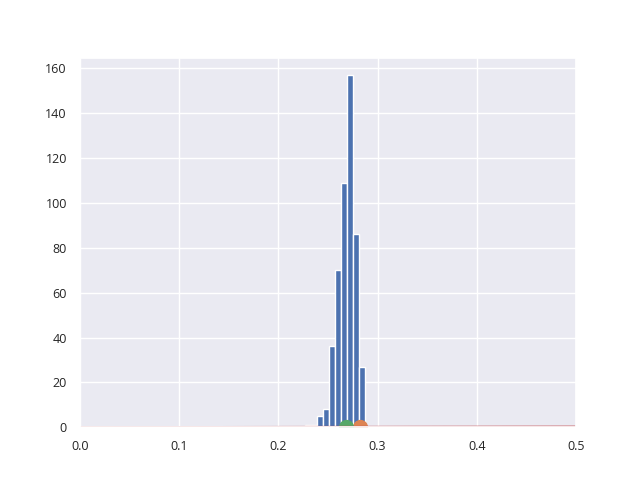

In [48]:
plt.figure()
plt.hist((X_r_rec[-5000:,:]**2.).mean(axis=0))
plt.xlim([0.,.5])
plt.plot([(y_rec[-5000:,:]**2.).mean()],[0.],'.',markersize=20)
plt.plot([(X_r_rec[-5000:,:]**2.).mean()],[0.],'.',markersize=20)
plt.show()